<a href="https://colab.research.google.com/github/sinthoras50/AIP-project/blob/main/AIP_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
!rm -rf /content/*

DATASET_NUM = 2
src = f'raw.githubusercontent.com/sinthoras50/AIP-project/main/images/{DATASET_NUM}'
frames_path = f'{src}/frames.csv'
polygons_path = f'{src}/polygons.mat'

!wget {frames_path}
!wget {polygons_path}

target_directory = 'images'
!mkdir -p {target_directory}

frames = []
NUM_IMAGES = 20

assert 0 < NUM_IMAGES <= 100

with open('frames.csv', 'r') as f:
  lines = f.readlines()
  for i, line in enumerate(lines):
    if i == NUM_IMAGES: break

    line = line.strip()
    frames.append(line.split('.')[0])

    image_url = f'raw.githubusercontent.com/sinthoras50/AIP-project/main/images/{DATASET_NUM}/{line}'
    !wget -P {target_directory} {image_url}

--2024-12-30 17:14:28--  http://raw.githubusercontent.com/sinthoras50/AIP-project/main/images/2/frames.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://raw.githubusercontent.com/sinthoras50/AIP-project/main/images/2/frames.csv [following]
--2024-12-30 17:14:28--  https://raw.githubusercontent.com/sinthoras50/AIP-project/main/images/2/frames.csv
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1600 (1.6K) [text/plain]
Saving to: ‘frames.csv’

frames.csv          100%[===================>]   1.56K  --.-KB/s    in 0s      

2024-12-30 17:14:28 (23.7 MB/s) - ‘frames.csv’ saved [1600/1600]

URL transformed to HTTPS due to an HSTS

In [2]:
import scipy.io
import cv2
import numpy as np
from matplotlib import pyplot as plt

!pip install ipympl
from google.colab import output
output.enable_custom_widget_manager()
%matplotlib ipympl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.6 MB/s eta 0:00:00


In [32]:
mat = scipy.io.loadmat('polygons.mat')
labelled_frames = []

for i, frame in enumerate(frames):
  labelled_frame = {
    'frame': frame,
    'myleft': mat['polygons'][0][i][0],
    'myright': mat['polygons'][0][i][1],
    'yourleft': mat['polygons'][0][i][2],
    'yourright': mat['polygons'][0][i][3]
  }

  labelled_frames.append(labelled_frame)

print(labelled_frames[2]['frame'])

frame_0100


# Ground truth API

In [4]:
def get_labelled_frame(frame_name):
  labelled_frame = [label for label in labelled_frames if label['frame'] == frame_name]

  if len(labelled_frame) == 0:
    return

  return labelled_frame[0]


def get_segmentation_mask(frame):
  assert type(frame) == dict, 'Frame must be a dictionary'

  img_mask = np.zeros((720, 1280), np.float32)

  if frame['myleft'].shape != (1, 0):
    myleft_points = [(int(x), int(y)) for x, y in frame['myleft']]
    cv2.fillPoly(img_mask, [np.array(myleft_points, dtype=np.int32)], 255)
  if frame['myright'].shape != (1, 0):
    myright_points = [(int(x), int(y)) for x, y in frame['myright']]
    cv2.fillPoly(img_mask, [np.array(myright_points, dtype=np.int32)], 255)
  if frame['yourleft'].shape != (1, 0):
    yourleft_points = [(int(x), int(y)) for x, y in frame['yourleft']]
    cv2.fillPoly(img_mask, [np.array(yourleft_points, dtype=np.int32)], 255)
  if frame['yourright'].shape != (1, 0):
    yourright_points = [(int(x), int(y)) for x, y in frame['yourright']]
    cv2.fillPoly(img_mask, [np.array(yourright_points, dtype=np.int32)], 255)

  return img_mask

# TODO
def get_frame_features(frame_name):
  ...


# Accuracy evaluation

In [5]:
def evaluate_iou(segmented_imgs, ground_truth_imgs):
  total_intersection_area = 0
  total_union_area = 0
  for si, gti in zip(segmented_imgs, ground_truth_imgs):
    intersection = cv2.bitwise_and(si, gti)
    union = cv2.bitwise_or(si, gti)

    total_intersection_area += np.sum(intersection)
    total_union_area += np.sum(union)

  return total_intersection_area / total_union_area if total_union_area > 0 else 0

# Calculate dataset image statistics, identify features

In [97]:
convex_hull_areas = []
polygon_areas = []
bbox_areas = []
solidities = [] # polygon area / convex hull area
extents = [] # polygon area / bbox area
aspect_ratios = [] # bbox width / bbox height
rectangularities = [] # bbox area / polygon area

# color based features
# TODO

for labelled_frame in labelled_frames:
  _polygon_areas = []
  _convex_hull_areas = []
  _bbox_areas = []
  _aspect_ratios = []

  for polygon in ['myleft', 'myright', 'yourleft', 'yourright']:
    if labelled_frame[polygon].shape != (1, 0):
      pts = np.array(labelled_frame[polygon], dtype=np.int32)

      hull = cv2.convexHull(pts)
      hull_area = cv2.contourArea(hull)
      _convex_hull_areas.append(hull_area)

      polygon_area = cv2.contourArea(pts)
      _polygon_areas.append(polygon_area)

      rect = cv2.minAreaRect(pts) # [[cx, cy], [w, h], [rotation]]
      box = cv2.boxPoints(rect)
      box = box.astype(np.int32)
      width, height = rect[1]

      aspect_ratio = width / height
      _aspect_ratios.append(aspect_ratio)

      bbox_area = width * height
      _bbox_areas.append(bbox_area)


  convex_hull_areas.append(_convex_hull_areas)
  polygon_areas.append(_polygon_areas)
  aspect_ratios.append(_aspect_ratios)
  bbox_areas.append(_bbox_areas)



# polygon area / convex hull area
for h_areas, p_areas in zip(convex_hull_areas, polygon_areas):
  _solidities = []

  for h_area, p_area in zip(h_areas, p_areas):
    _solidities.append(p_area / h_area)

  solidities.append(_solidities)

# polygon area / bbox area
# bbox area / polygon area
for bb_areas, p_areas in zip(bbox_areas, polygon_areas):
  _extents = []
  _rectangularities = []

  for bbox_area, p_area in zip(bb_areas, p_areas):
    _extents.append(p_area / bbox_area)
    _rectangularities.append(bbox_area / p_area)

  extents.append(_extents)
  rectangularities.append(_rectangularities)

# print(ratios)

flat_c_hull_areas = [x for xs in convex_hull_areas for x in xs]
flat_polygon_areas = [x for xs in polygon_areas for x in xs]
flat_solidities = [x for xs in solidities for x in xs]
flat_bbox_areas = [x for xs in bbox_areas for x in xs]
flat_extents = [x for xs in extents for x in xs]
flat_rectangularities = [x for xs in rectangularities for x in xs]
flat_aspect_ratios = [x for xs in aspect_ratios for x in xs]

features_obj = {
  'convex_hull_areas': convex_hull_areas,
  'polygon_areas': polygon_areas,
  'bbox_areas': bbox_areas,
  'solidities': solidities,
  'extents': extents,
  'rectangularities': rectangularities,
  'aspect_ratios': aspect_ratios,
  'avg_c_hull_area': np.mean(flat_c_hull_areas),
  'avg_polygon_area': np.mean(flat_polygon_areas),
  'avg_solidity': np.mean(flat_solidities),
  'avg_bbox_area': np.mean(flat_bbox_areas),
  'avg_extent': np.mean(flat_extents),
  'avg_rectangularity': np.mean(flat_rectangularities),
  'avg_aspect_ratio': np.mean(flat_aspect_ratios),
  'max_c_hull_area': np.max(flat_c_hull_areas),
  'max_polygon_area': np.max(flat_polygon_areas),
  'max_solidity': np.max(flat_solidities),
  'max_bbox_area': np.max(flat_bbox_areas),
  'max_extent': np.max(flat_extents),
  'max_rectangularity': np.max(flat_rectangularities),
  'max_aspect_ratio': np.max(flat_aspect_ratios),
  'min_c_hull_area': np.min(flat_c_hull_areas),
  'min_polygon_area': np.min(flat_polygon_areas),
  'min_solidity': np.min(flat_solidities),
  'min_bbox_area': np.min(flat_bbox_areas),
  'min_extent': np.min(flat_extents),
  'min_rectangularity': np.min(flat_rectangularities),
  'min_aspect_ratio': np.min(flat_aspect_ratios)
}

def normalize_feature(value, feature_name):
  assert f'avg_{feature_name}' in features_obj, f'Feature {feature_name} not found'

  min_val = features_obj[f'min_{feature_name}']
  max_val = features_obj[f'max_{feature_name}']
  return (value - min_val) / (max_val - min_val)

def detect_features(polygon):
  pts = np.array(polygon, dtype=np.int32)

  hull = cv2.convexHull(pts)
  hull_area = cv2.contourArea(hull)
  polygon_area = cv2.contourArea(pts)

  rect = cv2.minAreaRect(pts) # [[cx, cy], [w, h], [rotation]]
  box = cv2.boxPoints(rect)
  box = box.astype(np.int32)
  width, height = rect[1]
  aspect_ratio = width / height if height > 0 else 0
  bbox_area = width * height
  solidity = polygon_area / hull_area if hull_area > 0 else 0
  extent = polygon_area / bbox_area if bbox_area > 0 else 0
  rectangularity = bbox_area / polygon_area if polygon_area > 0 else 0

  return {
      'c_hull_area': hull_area,
      'polygon_area': polygon_area,
      'aspect_ratio': aspect_ratio,
      'bbox_area': bbox_area,
      'solidity': solidity,
      'extent': extent,
      'rectangularity': rectangularity
  }


# TODO implement weights
def compute_score(detected_features):
  normalized_features = []

  for key, value in detected_features.items():
    normalized_value = normalize_feature(value, key)
    normalized_features.append(normalized_value)

  distance = np.linalg.norm(np.array(normalized_features) - np.array(hand_descriptors))
  return distance

hand_descriptors = [normalize_feature(value, key[4:]) for key, value in features_obj.items() if 'avg' in key]

for key, value in features_obj.items():
  if key not in ('convex_hull_areas', 'polygon_areas', 'ratios', 'bbox_areas', 'solidities', 'rectangularities', 'aspect_ratios', 'extents'):
    print(f'{key}: {value}')

print(hand_descriptors)



avg_c_hull_area: 25324.49090909091
avg_polygon_area: 22332.19090909091
avg_solidity: 0.883658953265415
avg_bbox_area: 33494.06394202588
avg_extent: 0.66433541554065
avg_rectangularity: 1.5366056880260412
avg_aspect_ratio: 1.325095989625776
max_c_hull_area: 61614.5
max_polygon_area: 54356.0
max_solidity: 0.9885022462499048
max_bbox_area: 81552.0159127973
max_extent: 0.7879332007500139
max_rectangularity: 3.210001107385024
max_aspect_ratio: 4.6705964686379255
min_c_hull_area: 1942.0
min_polygon_area: 1535.5
min_solidity: 0.4576816796285218
min_bbox_area: 2414.0
min_extent: 0.3115263722804862
min_rectangularity: 1.269143119046291
min_aspect_ratio: 0.11971830985915492
[0.39184701343317124, 0.39372385549343364, 0.8024882614255014, 0.3927324129059946, 0.7405625238277423, 0.1378063570785431, 0.26486705152530043]


# Segmentation masks testing

frame_0359


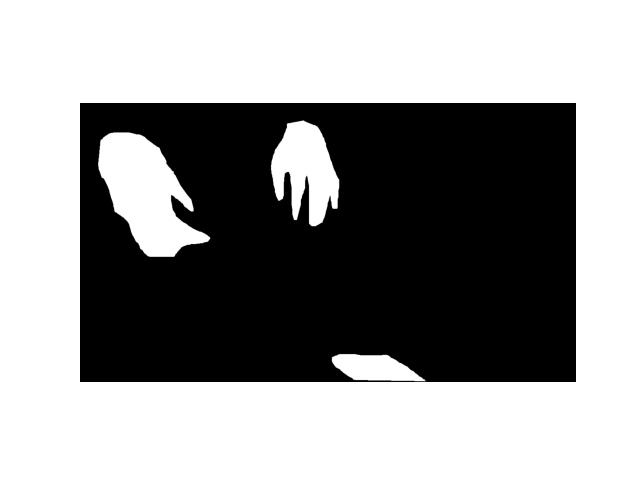

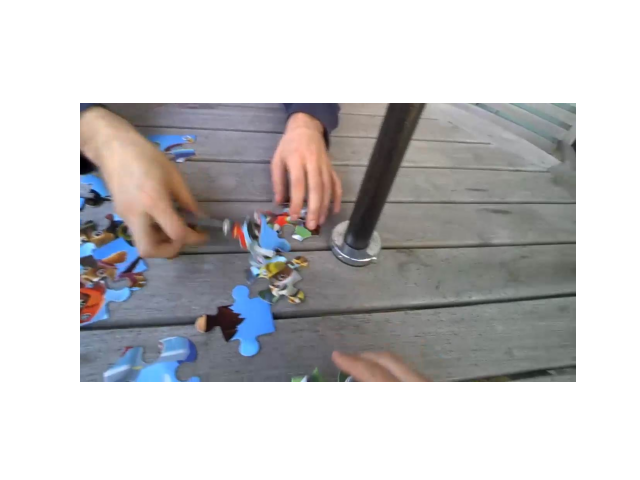

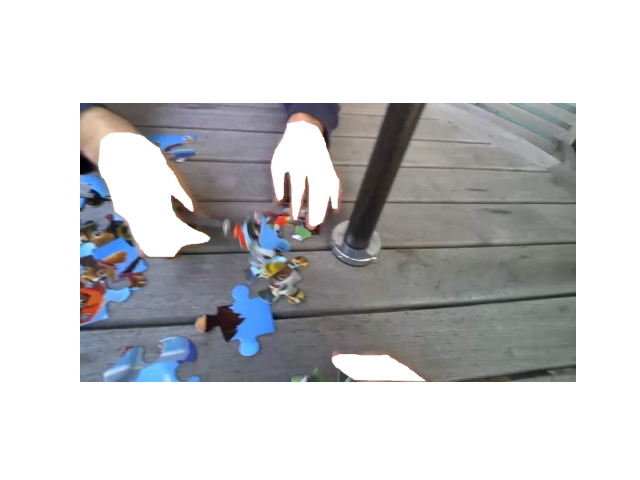

In [6]:
# TEST segmentation masks
FRAME_NUM = 13

frame_name = labelled_frames[FRAME_NUM]['frame']
print(frame_name)

frame = get_labelled_frame(frame_name)
mask = get_segmentation_mask(frame)

plt.figure()
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.show()

img = cv2.imread(f'images/{frame_name}.jpg')

plt.figure()
plt.imshow(img[:,:,::-1])
plt.axis('off')
plt.show()

overlayed_img = img.copy()
overlayed_img[mask == 255] = (255, 255, 255)

plt.figure()
plt.imshow(overlayed_img[:,:,::-1])
plt.axis('off')
plt.show()


# Image preprocessing methods

In [7]:
# Image preprocessing
# Color correction methods

def adaptive_eq_hist(img):
  # create a CLAHE object (Arguments are optional).
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  return clahe.apply(img)

def colored_eq_hist(img):
  ycrcb_img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
  ycrcb_img[:, :, 0] = cv2.equalizeHist(ycrcb_img[:, :, 0])
  equalized_img = cv2.cvtColor(ycrcb_img, cv2.COLOR_YCrCb2BGR)
  return equalized_img

def enhance_image(image):
  hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
  value_channel = hsv_image[:,:,2]
  eq_value_channel = cv2.equalizeHist(value_channel)
  hsv_image[:,:,2] = eq_value_channel
  enhanced_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)
  return enhanced_image

def posterize(img, k):
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 5, 1.0)
  ret, labels, centers = cv2.kmeans(img.reshape((-1, 3)).astype(np.float32), k, None, criteria, 10, cv2.KMEANS_PP_CENTERS)
  centers = centers.astype(np.uint8)
  result = centers[labels.flatten()]
  result = result.reshape((img.shape))

  return result

# Image preprocessing tests

frame_0359


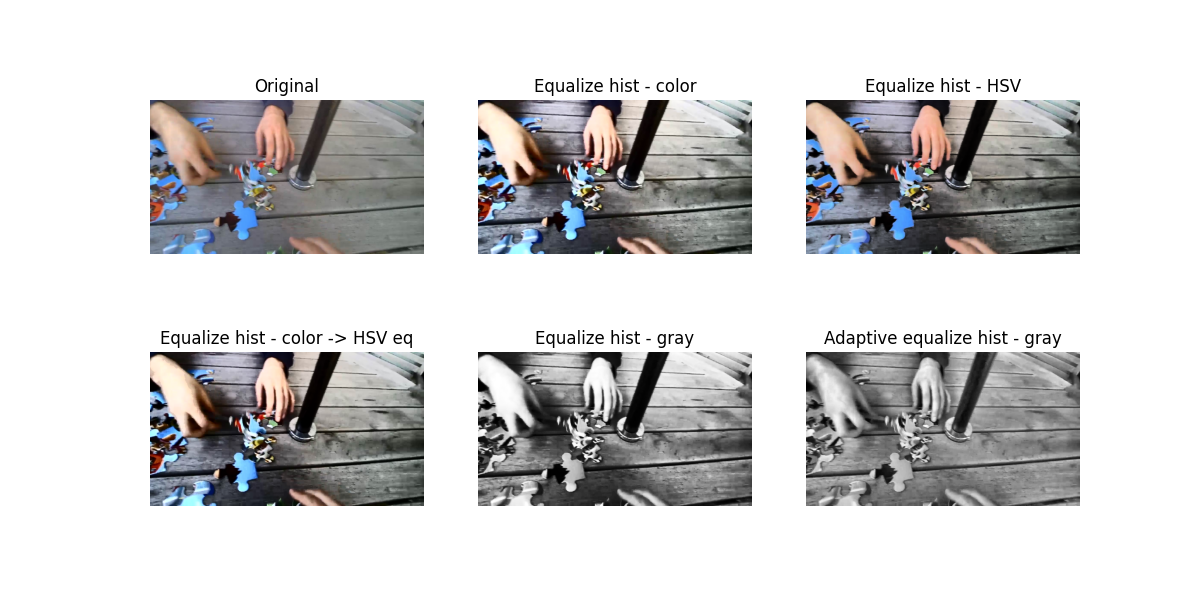

In [8]:
FRAME_NUM = 13

frame_name = labelled_frames[FRAME_NUM]['frame']
print(frame_name)

img = cv2.imread(f'images/{frame_name}.jpg')

plt.figure(figsize=(12, 6))

plt.subplot(2, 3, 1)
plt.title('Original')
plt.imshow(img[:,:,::-1])
plt.axis('off')

equalized_ycrcb = colored_eq_hist(img)

plt.subplot(2, 3, 2)
plt.title('Equalize hist - color')
plt.imshow(equalized_ycrcb[:,:,::-1])
plt.axis('off')

enhanced = enhance_image(img)

plt.subplot(2, 3, 3)
plt.title('Equalize hist - HSV')
plt.imshow(enhanced[:,:,::-1])
plt.axis('off')

enhanced_equalized_ycrcb = enhance_image(equalized_ycrcb)

plt.subplot(2, 3, 4)
plt.title('Equalize hist - color -> HSV eq')
plt.imshow(enhanced_equalized_ycrcb[:,:,::-1])
plt.axis('off')

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
equalized_gray = cv2.equalizeHist(gray)

plt.subplot(2, 3, 5)
plt.title('Equalize hist - gray')
plt.imshow(equalized_gray, cmap='gray')
plt.axis('off')

equalized_adaptive_gray = adaptive_eq_hist(gray)

plt.subplot(2, 3, 6)
plt.title('Adaptive equalize hist - gray')
plt.imshow(equalized_adaptive_gray, cmap='gray')
plt.axis('off')
plt.show()

to_test = [
    (img, 'original'),
    (equalized_ycrcb, 'equalized_ycrcb'),
    (enhanced, 'enhanced'),
    (enhanced_equalized_ycrcb, 'enhanced_equalized_ycrcb'),
    (equalized_gray, 'equalized_gray'),
    (equalized_adaptive_gray, 'equalized_adaptive_gray')
  ]

# K-means segmentation tests

frame_0105


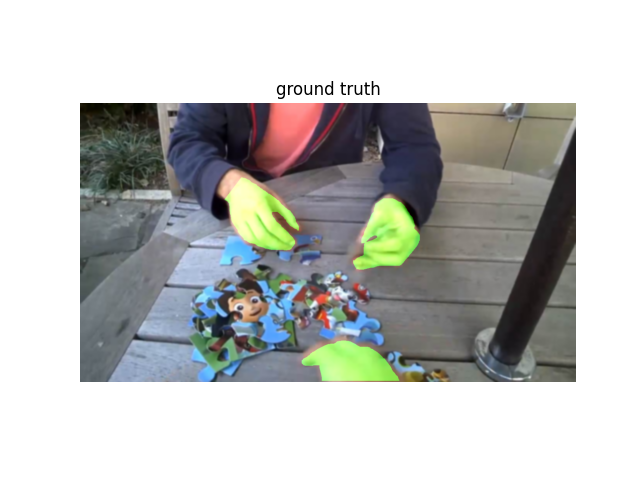

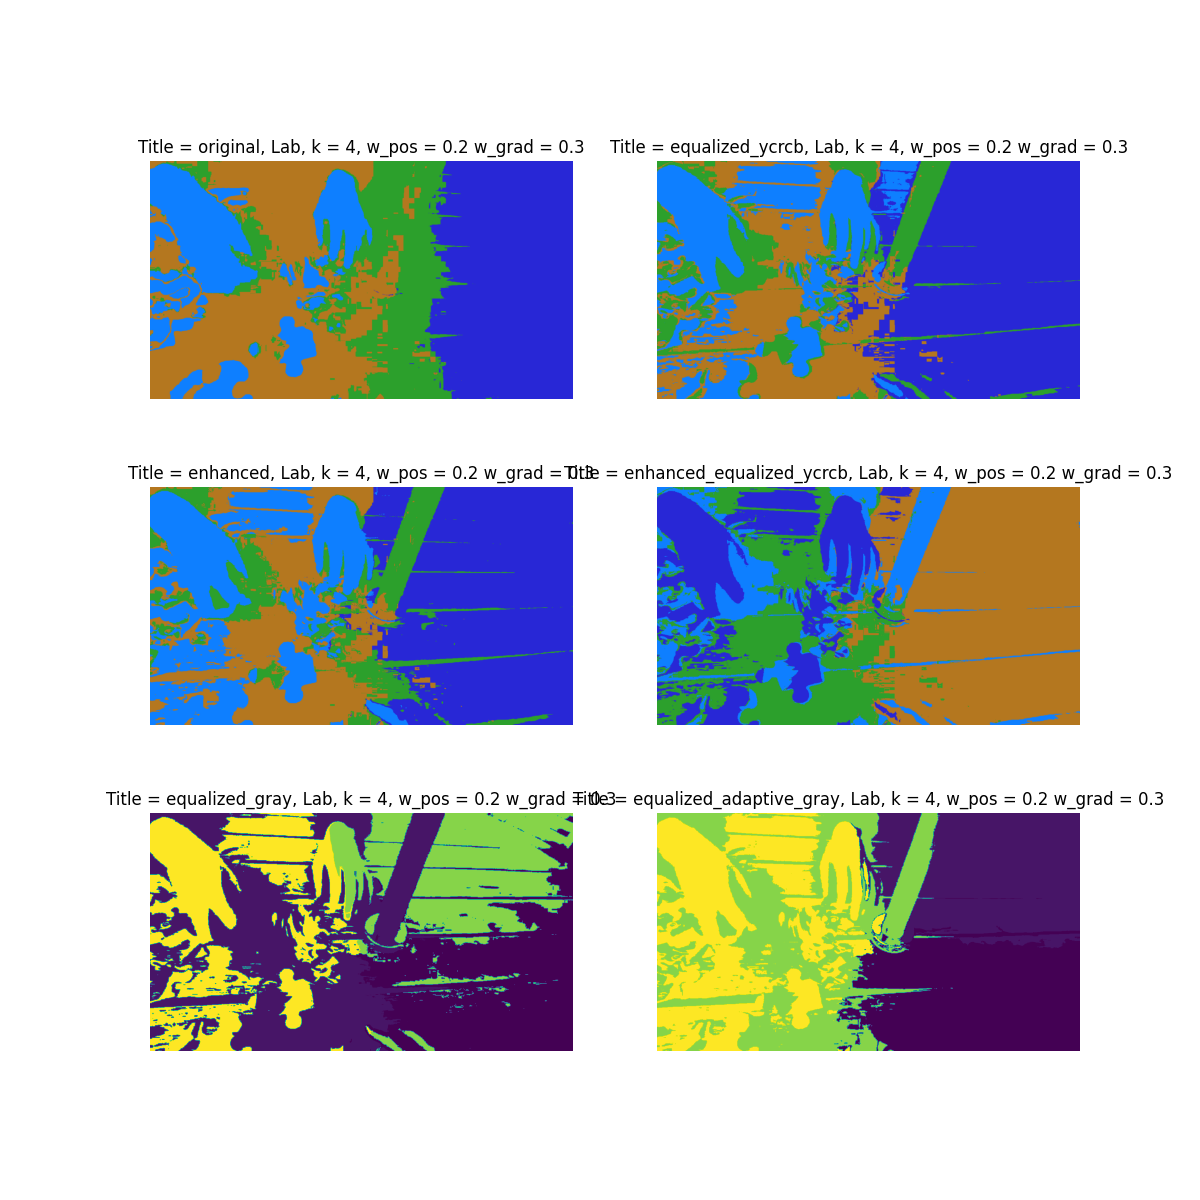

In [9]:
# K-means segmentation testing

def segment_k_means(img, k, conversion=None, position_w=0, gradient_w=0):
  original_img = img.copy()

  if conversion is not None and len(img.shape) == 3:
    img = cv2.cvtColor(img, conversion)

  img = img.astype(np.float32)

  h, w = img.shape[:2]
  # print(h, w)

  pixels = img.reshape((h * w, -1))

  if position_w > 0:
    x, y = np.meshgrid(range(w), range(h))
    x = x.reshape(h * w)
    y = y.reshape(h * w)
    positions = np.column_stack([x, y]).astype(np.float32)
    pixels = np.column_stack((pixels, position_w * positions))

  if gradient_w > 0:
    gray_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY) if len(original_img.shape) == 3 else img
    grad_x = cv2.Sobel(gray_img, cv2.CV_32F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(gray_img, cv2.CV_32F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(grad_x ** 2 + grad_y ** 2)
    gradients = gradient_w * gradient_magnitude.flatten()[:, None]
    pixels = np.column_stack((pixels, gradients))


  # pixel_shape = pixels.shape
  # print(pixels[pixel_shape[0]//2:pixel_shape[0]//2+20])

  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
  _, labels, centers = cv2.kmeans(pixels, k, None, criteria, 3, cv2.KMEANS_RANDOM_CENTERS)

  # Reshape the labels to match the original image shape
  segmentation = labels.reshape((h, w))

  return segmentation

def label_overlay(img, labels):
  k = np.max(labels) + 1
  cmap = plt.get_cmap('tab10')  # You can choose a different colormap if needed
  h, w = img.shape[:2]

  if len(img.shape) == 3:
    overlay = np.zeros((h, w, 3), dtype=np.uint8)
  else:  # If image is grayscale
    overlay = np.zeros((h, w), dtype=np.uint8)

  for label in range(k):
    color = np.array(cmap(label)[:3]) * 255

    if len(img.shape) == 2:
      color = color[0]

    overlay[labels == label] = color

  # Combine the image and overlay
  # output = cv2.addWeighted(img, 1.0, overlay, 0.5, 0)
  # return output

  return overlay


FRAME_NUM = 3

frame_name = labelled_frames[FRAME_NUM]['frame']
print(frame_name)

frame = get_labelled_frame(frame_name)
mask = get_segmentation_mask(frame)
img = cv2.imread(f'images/{frame_name}.jpg')

# apply gaussian
img = cv2.GaussianBlur(img, (9, 9), 0)

masked_img = img.copy()
masked_img = masked_img.astype(np.float32)
masked_img[mask == 255] += [0, 125, 0]
masked_img = np.clip(masked_img, 0, 255)
masked_img = masked_img.astype(np.uint8)

plt.figure()
plt.imshow(masked_img[:,:,::-1])
plt.title('ground truth')
plt.axis('off')
plt.show()

k = 4
pw = 0.2
gw = 0.3

plt.figure(figsize=(12, 12))

for i, (img, title) in enumerate(to_test):
  overlayed = label_overlay(img, segment_k_means(img, k, cv2.COLOR_BGR2HSV, position_w=pw, gradient_w=gw))
  if len(overlayed.shape) == 3:
    overlayed = overlayed[:, :, ::-1]

  plt.subplot(3, 2, i+1)
  plt.imshow(overlayed)

  plt.title(f'Title = {title}, Lab, k = {k}, w_pos = {pw} w_grad = {gw}')
  plt.axis("off")

plt.show()



# Image preprocessing using posterize + Color based segmentation

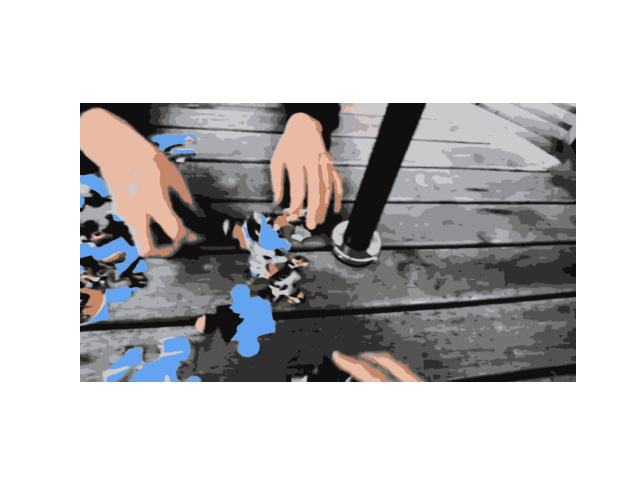

15

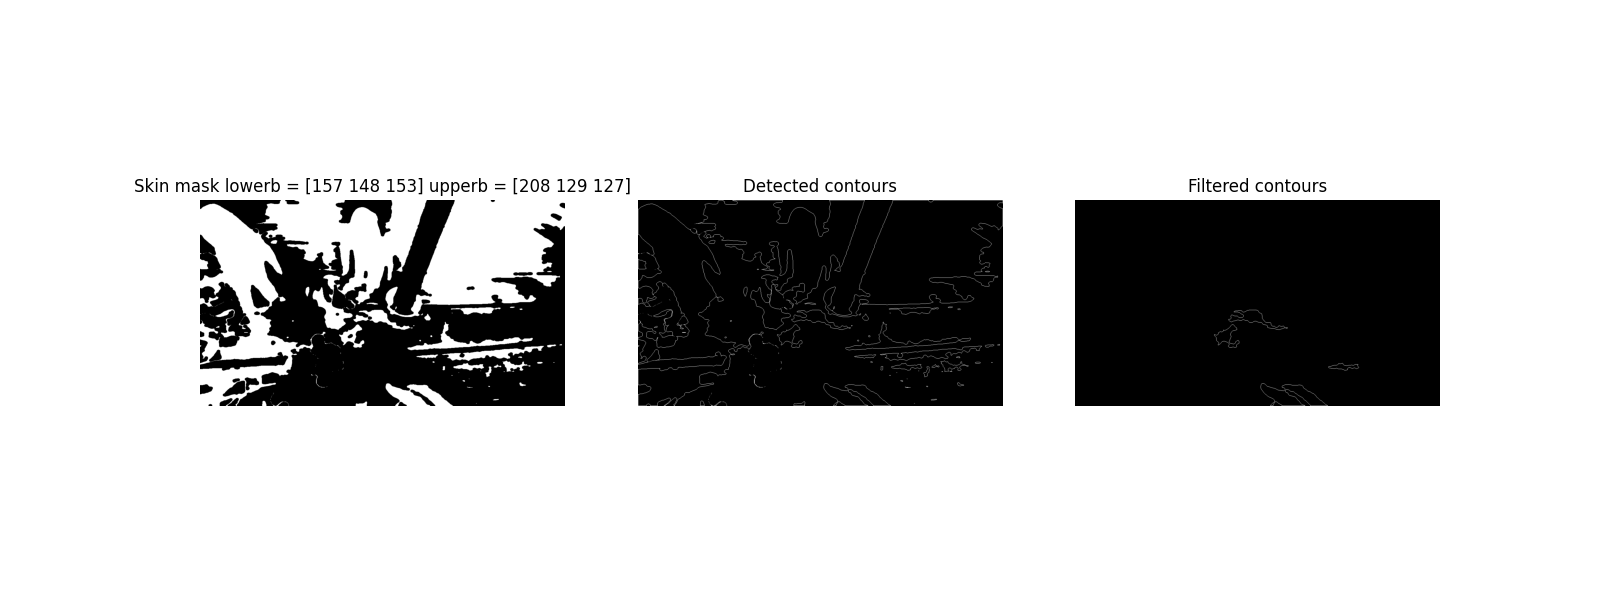

In [106]:
# testing of image preprocessing

def detect_skin(img, lower_bound, upper_bound):
  mask = cv2.inRange(img, lower_bound, upper_bound)
  return mask

# click to select the lower/upper skin color bounds
def onclick(event):
  global buff, color_space, img_axes
  ix, iy = event.xdata, event.ydata

  if ix is None or iy is None:
    return

  # print(ix, iy)
  # print(converted_img[int(iy), int(ix)])
  buff.append(converted_img[int(iy), int(ix)])

  if len(buff) == 2:
    lower_bound = np.min(buff, axis=0)
    # lower_bound = buff[0]
    upper_bound = np.max(buff, axis=0)
    # upper_bound = buff[1]

    if color_space == cv2.COLOR_BGR2LAB:
      tolerance = [7, 5, 5]  # LAB tolerances
      lower_bound = np.clip(lower_bound - tolerance, 0, 255)
      upper_bound = np.clip(upper_bound + tolerance, 0, 255)

    elif color_space == cv2.COLOR_BGR2HSV:
      tolerance = [10, 20, 25]  # HSV tolerances
      # cyclic hue
      lower_bound[0] = (lower_bound[0] - tolerance[0]) % 180
      upper_bound[0] = (upper_bound[0] + tolerance[0]) % 180
      lower_bound[1:] = np.clip(lower_bound[1:] - tolerance[1:], 0, 255)
      upper_bound[1:] = np.clip(upper_bound[1:] + tolerance[1:], 0, 255)

    segment_hand(converted_img, lower_bound, upper_bound)
    buff = []

def segment_hand(img, lower_bound, upper_bound):
  global fig2, img_axes

  if not fig2:
    fig2, img_axes = plt.subplots(1, 3, figsize=(16, 6))  # Create 3 subplots

    for ax in img_axes:
      ax.axis('off')


  skin_mask = detect_skin(converted_img, lower_bound, upper_bound)
  se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
  closed_mask = cv2.morphologyEx(skin_mask, cv2.MORPH_CLOSE, se)

  cnts, _ = cv2.findContours(closed_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  scored_cnts = []

  min_contour_area = features_obj['min_polygon_area'] * 0.75
  filtered_contours = [cnt for cnt in cnts if cv2.contourArea(cnt) > min_contour_area]

  for cnt in filtered_contours:
    reshaped = cnt.reshape((-1, 2))
    features = detect_features(reshaped)
    score = compute_score(features)
    # print(score)
    scored_cnts.append((score, cnt))

  cnts_img = np.zeros_like(closed_mask)
  cv2.drawContours(cnts_img, cnts, -1, 255)

  scored_cnts.sort(key=lambda x: x[0])
  filtered_cnts = [x[1] for x in scored_cnts][:4]
  filtered_cnts_img = np.zeros_like(closed_mask)
  cv2.drawContours(filtered_cnts_img, filtered_cnts, -1, 255)

  img_axes[0].set_title(f'Skin mask lowerb = {buff[0]} upperb = {buff[1]}')
  img_axes[1].set_title('Detected contours')
  img_axes[2].set_title('Filtered contours')

  img_axes[0].imshow(closed_mask, cmap='gray')
  img_axes[1].imshow(cnts_img, cmap='gray')
  img_axes[2].imshow(filtered_cnts_img, cmap='gray')

  plt.draw()


FRAME_NUM = 13
frame_name = labelled_frames[FRAME_NUM]['frame']
img = cv2.imread(f'images/{frame_name}.jpg')

buff = []
color_space = cv2.COLOR_BGR2LAB

blurred = cv2.GaussianBlur(img, (9, 9), 0)
enhanced = enhance_image(blurred)
posterized = posterize(enhanced, 10)

converted_img = cv2.cvtColor(posterized, color_space)

plt.close('all')
fig = plt.figure()
fig2, img_axes = None, None
plt.imshow(posterized[:,:,::-1])
plt.axis('off')
plt.show()

fig.canvas.mpl_connect('button_press_event', onclick)